In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("DadosVendasBM.csv", delimiter=';')
df.head(5)

,Data,Dia,Mês,Dia da Semana,Precipitacao,Temperatura,Vendas,Ticket Médio,Valor Total
0,02/06/2023,2,6,6,0,"18,2",80,"R$ 23,39","R$ 1.871,00"
1,03/06/2023,3,6,7,0,"21,1",200,"R$ 26,99","R$ 5.397,00"
2,04/06/2023,4,6,1,0,"21,5",114,"R$ 24,99","R$ 2.849,00"
3,05/06/2023,5,6,2,0,"19,7",74,"R$ 26,52","R$ 1.915,67"
4,06/06/2023,6,6,3,0,"17,7",23,"R$ 20,83","R$ 479,00"


In [3]:
# Estatísticas descritivas para variáveis numéricas
print(df.describe())

# Verificar as informações gerais do DataFrame
print(df.info())


              Dia         Mês  Dia da Semana      Vendas
count  357.000000  357.000000     357.000000  357.000000
mean    15.817927    6.509804       4.016807   74.044818
std      8.922759    3.498481       2.011134   43.049856
min      1.000000    1.000000       1.000000    4.000000
25%      8.000000    3.000000       2.000000   40.000000
50%     16.000000    6.000000       4.000000   74.000000
75%     24.000000   10.000000       6.000000   94.000000
max     31.000000   12.000000       7.000000  288.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Data           357 non-null    object
 1   Dia            357 non-null    int64 
 2   Mês            357 non-null    int64 
 3   Dia da Semana  357 non-null    int64 
 4   Precipitacao   357 non-null    object
 5   Temperatura    357 non-null    object
 6   Vendas         357 non-null    int

In [4]:
# Converter colunas relevantes para numéricas
df['Temperatura'] = df['Temperatura'].str.replace(',', '.').astype(float)
df['Ticket Médio'] = df['Ticket Médio'].str.replace('R$', '').str.replace('.', '').str.replace(',', '.').astype(float)
df['Valor Total'] = df['Valor Total'].str.replace('R$', '').str.replace('.', '').str.replace(',', '.').astype(float)


In [5]:
# Verificar as informações gerais do DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Data           357 non-null    object 
 1   Dia            357 non-null    int64  
 2   Mês            357 non-null    int64  
 3   Dia da Semana  357 non-null    int64  
 4   Precipitacao   357 non-null    object 
 5   Temperatura    357 non-null    float64
 6   Vendas         357 non-null    int64  
 7   Ticket Médio   357 non-null    float64
 8   Valor Total    357 non-null    float64
dtypes: float64(3), int64(4), object(2)
memory usage: 25.2+ KB
None


In [9]:
# Remover as colunas desnecessárias antes de treinar o modelo
#df = df.drop(['Ticket Médio',], axis=1)
# Remover a coluna Precipitação
df = df.drop(['Precipitacao'], axis=1)



In [10]:
# 1. Verificar dados faltantes
print("Dados faltantes por coluna:")
print(df.isnull().sum())
print("\n")

# 2. Verificar se há valores que são strings especiais indicando dados faltantes
# Exemplo: "?" ou qualquer outro caractere que pode indicar falta de dados
special_missing_values = ['?', 'NA', 'N/A', '-', '--', 'null', 'Null', 'none', 'None']

for value in special_missing_values:
    print(f"Verificando '{value}'...")
    print(df.isin([value]).sum())
    print("\n")

# 3. Substituir valores faltantes ou inconsistentes por NaN
df.replace(special_missing_values, np.nan, inplace=True)

# 4. Verificar novamente após substituição para entender a extensão dos dados faltantes
print("Dados faltantes após substituição:")
print(df.isnull().sum())
print("\n")

Dados faltantes por coluna:
Data             0
Dia              0
Mês              0
Dia da Semana    0
Temperatura      0
Vendas           0
Valor Total      0
dtype: int64


Verificando '?'...
Data             0
Dia              0
Mês              0
Dia da Semana    0
Temperatura      0
Vendas           0
Valor Total      0
dtype: int64


Verificando 'NA'...
Data             0
Dia              0
Mês              0
Dia da Semana    0
Temperatura      0
Vendas           0
Valor Total      0
dtype: int64


Verificando 'N/A'...
Data             0
Dia              0
Mês              0
Dia da Semana    0
Temperatura      0
Vendas           0
Valor Total      0
dtype: int64


Verificando '-'...
Data             0
Dia              0
Mês              0
Dia da Semana    0
Temperatura      0
Vendas           0
Valor Total      0
dtype: int64


Verificando '--'...
Data             0
Dia              0
Mês              0
Dia da Semana    0
Temperatura      0
Vendas           0
Valor Total      0


In [11]:
# Função para garantir a conversão de colunas de string para float
def convert_to_numeric(df, column):
    if df[column].dtype == 'object':
        df[column] = df[column].str.replace(',', '.').str.replace('R$', '').str.replace('.', '').str.replace(',', '.').astype(float)

# Aplicar a conversão para as colunas relevantes
columns_to_convert = ['Temperatura', 'Valor Total', 'Vendas', 'Dia', 'Mês', 'Dia da Semana']
for column in columns_to_convert:
    convert_to_numeric(df, column)

# Verificar dados faltantes após a conversão
print("Dados faltantes por coluna após conversão:")
print(df.isnull().sum())


Dados faltantes por coluna após conversão:
Data             0
Dia              0
Mês              0
Dia da Semana    0
Temperatura      0
Vendas           0
Valor Total      0
dtype: int64


In [12]:
# Criar variáveis de interação
df['Temp_DiaSemana_Interaction'] = df['Temperatura'] * df['Dia da Semana']
df['Semana_Mes_Interaction'] = df['Dia da Semana'] * df['Mês']

In [19]:
# Definir a variável alvo (Valor Total) e as features
X = df[['Temperatura', 'Dia da Semana', 'Mês', 'Vendas', 'Temp_DiaSemana_Interaction', 'Semana_Mes_Interaction']]
y = df['Valor Total']


In [20]:
# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar o modelo XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Previsão
y_pred = model.predict(X_test)

R²: 0.95
MAE: 166.43
RMSE: 241.64


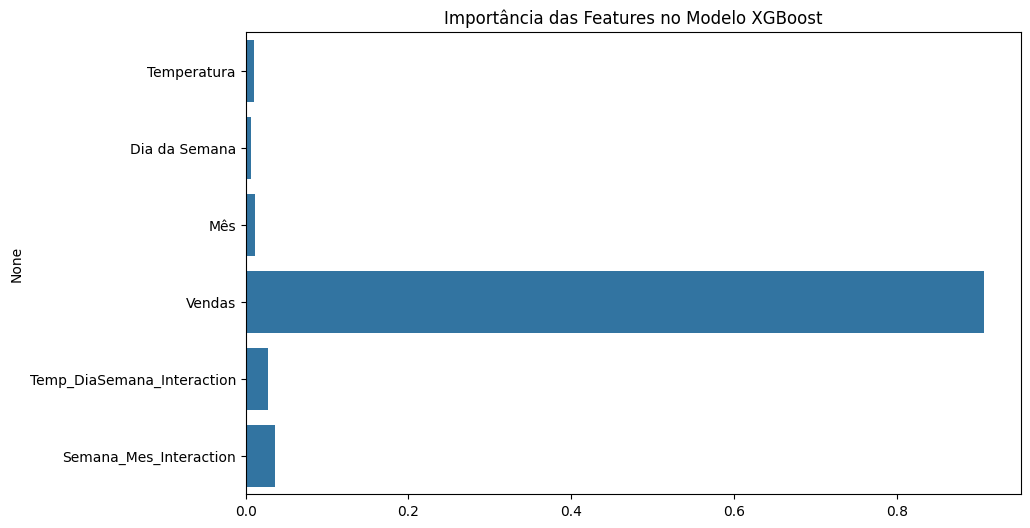

In [21]:
# Avaliação do modelo
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Importância das features
plt.figure(figsize=(10, 6))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title('Importância das Features no Modelo XGBoost')
plt.show()

In [22]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Carregar o conjunto de dados
df = pd.read_csv("DadosVendasBM.csv", delimiter=';')

# Converter colunas relevantes para numéricas
df['Temperatura'] = df['Temperatura'].str.replace(',', '.').astype(float)
df['Ticket Médio'] = df['Ticket Médio'].str.replace('R$', '').str.replace('.', '', regex=False).str.replace(',', '.').astype(float)
df['Valor Total'] = df['Valor Total'].str.replace('R$', '').str.replace('.', '', regex=False).str.replace(',', '.').astype(float)

# Criar as colunas de interação
df['Temp_DiaSemana_Interaction'] = df['Temperatura'] * df['Dia da Semana']
df['Semana_Mes_Interaction'] = df['Dia da Semana'] * df['Mês']

# Definir a variável alvo e as features
X = df[['Temperatura', 'Dia da Semana', 'Mês', 'Vendas', 'Temp_DiaSemana_Interaction', 'Semana_Mes_Interaction']]
y = df['Valor Total']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R²: {r2:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

# Salvar o modelo treinado em JSON
model.save_model("xgboost_model.json")
print("Modelo salvo como 'xgboost_model.json'")


R²: 0.93
MAE: 180.87
RMSE: 281.83
Modelo salvo como 'xgboost_model.json'
